# Lab: Batch Normalization and Transfer Learning



------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of CNNs Lab. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [41]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [42]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)        
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [52]:
from torch.utils.data import random_split

val_size = int(0.2 * len(trainset))
train_size = len(trainset) - val_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)


In [53]:
class MLP_extended(MLP):
    def __init__(self, dimx, hidden1, hidden2, nlabels, use_batch_norm, lr=0.001):
        super().__init__(dimx, hidden1, hidden2, nlabels, use_batch_norm)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.NLLLoss()
    
    def trainloop(self, trainloader, validloader, epochs=10):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            running_loss = 0.0
            self.train()

            for images, labels in trainloader:
                images = images.view(images.shape[0], -1)
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            train_losses.append(running_loss / len(trainloader))

            self.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in validloader:
                    images = images.view(images.shape[0], -1)
                    output = self.forward(images)
                    loss = self.criterion(output, labels)
                    val_loss += loss.item()

            val_losses.append(val_loss / len(validloader))

            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Training loss: {train_losses[-1]:.3f}.. "
                  f"Validation loss: {val_losses[-1]:.3f}")

        return train_losses, val_losses

    def evaluate(self, dataloader):
        accuracy = 0.0
        self.eval()

        with torch.no_grad():
            for images, labels in dataloader:
                images = images.view(images.shape[0], -1)
                output = self.forward(images)
                _, predicted = torch.max(output, 1)
                equals = predicted == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        return accuracy / len(dataloader)


### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

Entrenando modelo con Batch Normalization...
Epoch 1/10.. Training loss: 0.320.. Validation loss: 0.140
Epoch 2/10.. Training loss: 0.113.. Validation loss: 0.110
Epoch 3/10.. Training loss: 0.075.. Validation loss: 0.096
Epoch 4/10.. Training loss: 0.059.. Validation loss: 0.113
Epoch 5/10.. Training loss: 0.045.. Validation loss: 0.091
Epoch 6/10.. Training loss: 0.034.. Validation loss: 0.109
Epoch 7/10.. Training loss: 0.034.. Validation loss: 0.084
Epoch 8/10.. Training loss: 0.029.. Validation loss: 0.107
Epoch 9/10.. Training loss: 0.027.. Validation loss: 0.090
Epoch 10/10.. Training loss: 0.022.. Validation loss: 0.101
Entrenando modelo sin Batch Normalization...
Epoch 1/10.. Training loss: 0.479.. Validation loss: 0.291
Epoch 2/10.. Training loss: 0.245.. Validation loss: 0.218
Epoch 3/10.. Training loss: 0.179.. Validation loss: 0.171
Epoch 4/10.. Training loss: 0.143.. Validation loss: 0.167
Epoch 5/10.. Training loss: 0.118.. Validation loss: 0.145
Epoch 6/10.. Training lo

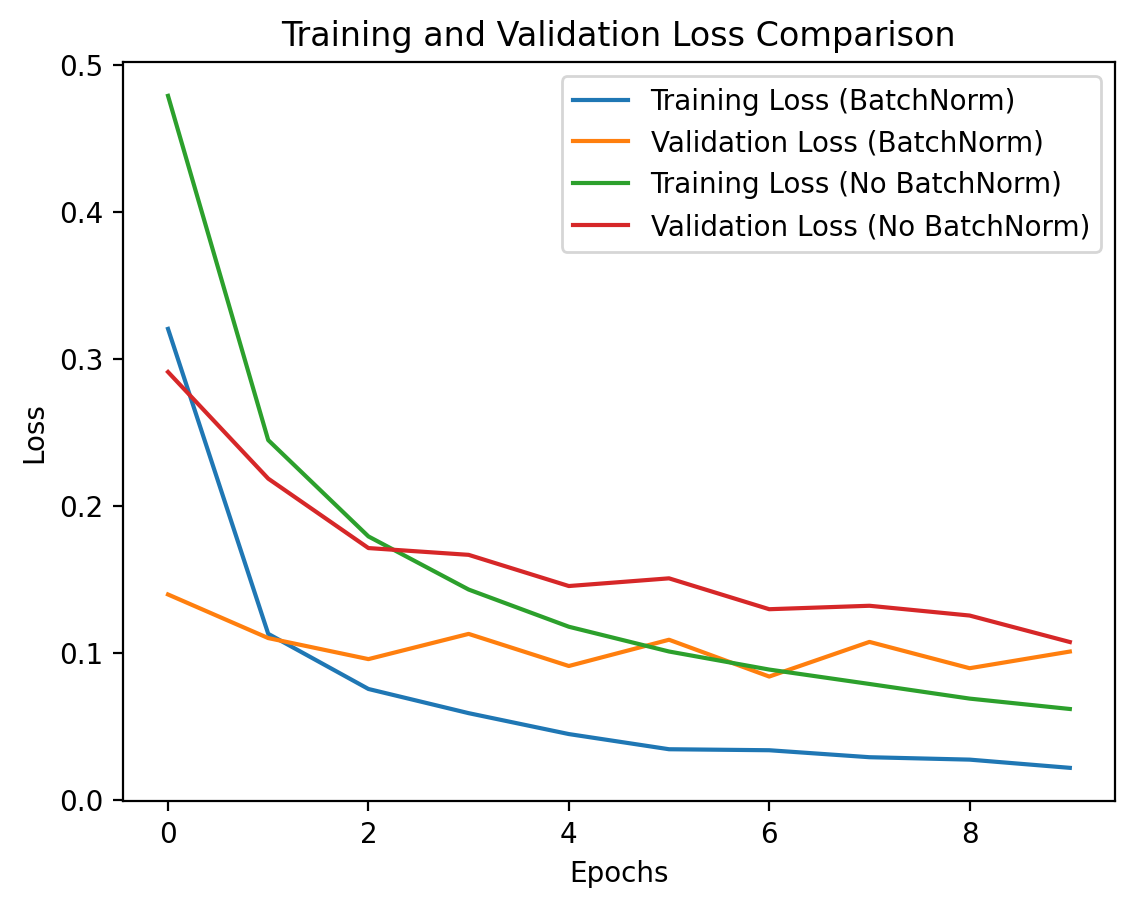

In [55]:
#YOUR CODE HERE
dimx = 28 * 28
hidden1 = 128
hidden2 = 64
nlabels = 10

net_batchnorm = MLP_extended(dimx, hidden1, hidden2, nlabels, use_batch_norm=True)
net_no_norm = MLP_extended(dimx, hidden1, hidden2, nlabels, use_batch_norm=False)

epochs = 10

print("Entrenando modelo con Batch Normalization...")
train_losses_bn, val_losses_bn = net_batchnorm.trainloop(trainloader, validloader, epochs=epochs)

print("Entrenando modelo sin Batch Normalization...")
train_losses_no_bn, val_losses_no_bn = net_no_norm.trainloop(trainloader, validloader, epochs=epochs)

test_accuracy_bn = net_batchnorm.evaluate(testloader)
test_accuracy_no_bn = net_no_norm.evaluate(testloader)

print(f"Test Accuracy (BatchNorm): {test_accuracy_bn * 100:.2f}%")
print(f"Test Accuracy (No BatchNorm): {test_accuracy_no_bn * 100:.2f}%")

plt.figure()

plt.plot(train_losses_bn, label="Training Loss (BatchNorm)")
plt.plot(val_losses_bn, label="Validation Loss (BatchNorm)")
plt.plot(train_losses_no_bn, label="Training Loss (No BatchNorm)")
plt.plot(val_losses_no_bn, label="Validation Loss (No BatchNorm)")

plt.title("Training and Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()


---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Using CIFAR10 database, incorporate BN to your solution of the previous lab on CNNs. Compare the results with and without BN!!

In [45]:
#YOUR CODE HERE

## Transfer Learning in Pytorch

In this section of the lab, you'll learn how to use pre-trained CNN networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. 

Once trained over Imagenet, CNNs models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy. With [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

In [46]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2016/08/knn_kaggle_dogs_vs_cats_sample.jpg", width=400, height=200)


We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

To run the notebook in Google Colab, we mount our Drive folder to later access the Cat & Dogs folder

In [48]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [56]:
path_to_folder = '/Users/felipeguzmanrod/Documents/IAA/Redes de Neuronas/LAB-3/CNN-Training-Lab/'  # Ruta actualizada

## Load the data set. Incorporate Data Augmentation

#### Dataset folder structure

The easiest way to load you own training/test image dataset is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a sequence of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. **More about this below**. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. 

You can check that the provided dataset has the required structure.

#### Data augmentation

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). 

A common technique to enforce the invariancy of the CNN and obtain a more robust classifier is [Data Augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced), which seeks to train the neural network with additional synthetically modified data, generated by introducing randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.


To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered other than normalizing. So, for validation/test images, you'll typically just resize and crop.


In this notebook, we will use [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) as feature extractor. It requires the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

With the following code, we load the dataset of cats & dogs, perform the data augmentation trasformations, and normalize the input images according to DenseNet.

In [57]:
data_dir = path_to_folder + 'Cat_Dog_data_reduced'

# Train Set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Test Set
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Lets visualize some images (they look weird because of the normalization)

In [58]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for ii in range(6):
    ax = axes[ii]
    ax.imshow(images[ii,:,:,:].numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.2184873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.535425].


## Loading DenseNet and modifing the last classification layer


[DensetNet](https://arxiv.org/abs/1608.06993) was proposed in the 2017 IEEE Conference on Computer Vision and Pattern Recognition, and it is one of the most popular CNNs for computer vision applications. 

The models is huge and contains millions of parameters. [This excellent post](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a) explains in detail the DenseNet structure. 

In [59]:
Image(url= "https://miro.medium.com/max/1138/1*GeK21UAbk4lEnNHhW_dgQA.png", width=400, height=200)

In [60]:
Image(url= "https://miro.medium.com/max/2846/1*SsphOqMwglCVGDWB-jdT5Q.png", width=800, height=200)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [61]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so **it won't work for our specific problem**. That means we need to replace the classifier, but the features will work perfectly on their own. In general, think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

Replacing the classifier is straightforward. We go step by step. 

> **Excercise:** Create a class for a NN binary classifier with two dense layers. Use 500 hidden units as the output dimension of the first layer.

In [62]:
class MLP(nn.Module):
    def __init__(self,dimx=1024,hidden=500,nlabels=2): 
        
        super().__init__()
        
        self.output1 = nn.Linear(dimx, hidden)
        
        self.output2 = nn.Linear(hidden, nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                           
        
    def forward(self, x):
        x = self.relu(self.output1(x))
        
        x = self.logsoftmax(self.output2(x))
        return x


Now, we instantiate the class `MLP` we just created and replace the classifier part of DenseNet. Also, we freeze the rest of DenseNet parameters.

In [63]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = MLP(1024)
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

> **Exercise**: Complete the following code for a class that trains the defined model.

Note that, to make things easier, this time we pass the instatiated model as an input to the class!

You will see that training is slow (every epoch can take more than one hour). Hence, the following code is prepared to be trained for only a few minibatches (we specify the number of SGD iterations, not epochs). In any case, since the features learnt by Densenet are very discriminative, the classifier performs well within only a few iterations! Also, to save time we do not compute validation loss. But to do it right and evaluate overfitting, you should implement it!

In [65]:
class Tran_Eval:
    def __init__(self, model, maxiter=500, lr=0.001):
        self.model = model
        self.lr = lr  # Tasa de aprendizaje
        self.optim = optim.Adam(self.model.classifier.parameters(), lr=self.lr)
        self.max_iter = maxiter
        self.criterion = nn.NLLLoss()  # Función de pérdida (Negative Log Likelihood)
        
        # Lista para almacenar la evolución de la pérdida durante el entrenamiento
        self.loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # Mover el modelo a la GPU o CPU
    
    def trainloop(self, trainloader):
        # Ciclo de optimización
        it_images = iter(trainloader)
        running_loss = 0.0
        self.model.train()  # Establecer el modelo en modo de entrenamiento

        for e in range(int(self.max_iter)):
            try:
                images, labels = next(it_images)
            except StopIteration:
                it_images = iter(trainloader)
                images, labels = next(it_images)
            
            # Mover los tensores de entrada y etiquetas al dispositivo (GPU/CPU)
            images, labels = images.to(self.device), labels.to(self.device)
            
            # Reiniciar los gradientes
            self.optim.zero_grad()
            
            # Hacer una pasada hacia adelante (forward pass)
            out = self.model(images)  # Forward pass para obtener las predicciones
            
            # Calcular la pérdida
            loss = self.criterion(out, labels)
            
            # Retropropagación
            loss.backward()
            
            # Actualizar los parámetros del modelo
            self.optim.step()

            running_loss = loss.item()
            self.loss_during_training.append(running_loss)
            
            # Imprimir el estado de cada batch (manteniendo el formato solicitado)
            print('Batch %d of %d finished. Loss %f' % (e + 1, self.max_iter, running_loss))

    def eval_performance(self, dataloader, num_batches):
        accuracy = 0.0
        it_images = iter(dataloader)

        # Desactivar los gradientes para la evaluación, lo que ahorra memoria y cálculos
        with torch.no_grad():
            self.model.eval()  # Establecer el modelo en modo de evaluación

            for e in range(int(num_batches)):
                print('Batch %d of %d' % (e + 1, num_batches))
                
                try:
                    images, labels = next(it_images)
                except StopIteration:
                    it_images = iter(dataloader)
                    images, labels = next(it_images)
                
                # Mover los tensores de entrada y etiquetas al dispositivo (GPU/CPU)
                images, labels = images.to(self.device), labels.to(self.device)

                # Pasada hacia adelante (forward pass)
                probs = self.model(images)

                # Obtener la clase más probable
                top_p, top_class = probs.topk(1, dim=1)
                
                # Comparar las predicciones con las etiquetas
                equals = (top_class == labels.view(images.shape[0], 1))
                
                # Calcular la precisión
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Calcular la precisión media en los lotes
        return accuracy / num_batches


>**Exercise:** Train the model for 10 iterations. Compute the train/test performance in the first 5 batches of the datasets

In [66]:
#YOUR CODE HERE
# Asumimos que ya has definido tu modelo (ej. DenseNet con un clasificador modificado)
# e instanciado el DataLoader para entrenamiento y prueba (trainloader y testloader).

# Instanciar la clase Tran_Eval con el modelo
trainer = Tran_Eval(model, maxiter=10, lr=0.001)

# Entrenamiento del modelo durante 10 iteraciones
trainer.trainloop(trainloader)

# Evaluar el rendimiento en los primeros 5 lotes del conjunto de entrenamiento
print("Evaluando en los primeros 5 lotes del conjunto de entrenamiento:")
train_accuracy = trainer.eval_performance(trainloader, num_batches=5)
print(f'Training Accuracy in first 5 batches: {train_accuracy * 100:.2f}%')

# Evaluar el rendimiento en los primeros 5 lotes del conjunto de prueba
print("Evaluando en los primeros 5 lotes del conjunto de prueba:")
test_accuracy = trainer.eval_performance(testloader, num_batches=5)
print(f'Test Accuracy in first 5 batches: {test_accuracy * 100:.2f}%')


Batch 1 of 10 finished. Loss 0.667881
Batch 2 of 10 finished. Loss 1.358470
Batch 3 of 10 finished. Loss 0.831019
Batch 4 of 10 finished. Loss 0.537133
Batch 5 of 10 finished. Loss 0.646839
Batch 6 of 10 finished. Loss 0.564433
Batch 7 of 10 finished. Loss 0.570278
Batch 8 of 10 finished. Loss 0.491429
Batch 9 of 10 finished. Loss 0.390577
Batch 10 of 10 finished. Loss 0.408121
Evaluando en los primeros 5 lotes del conjunto de entrenamiento:
Batch 1 of 5
Batch 2 of 5
Batch 3 of 5
Batch 4 of 5
Batch 5 of 5
Training Accuracy in first 5 batches: 80.94%
Evaluando en los primeros 5 lotes del conjunto de prueba:
Batch 1 of 5
Batch 2 of 5
Batch 3 of 5
Batch 4 of 5
Batch 5 of 5
Test Accuracy in first 5 batches: 87.50%
